### 5.5.2 完整的代码

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -- 各项设置参数 --
n_time = 10  # 时间序列数据的数量
n_in = 1  # 输入层的神经元数量
n_mid = 20  # 中间层的神经元数量
n_out = 1  # 输出层的神经元数量

eta = 0.01  # 学习系数
epochs = 500
batch_size = 4
interval = 10  # 显示处理进度的间隔

In [3]:
#  定义sigmoid函数控制输入 忘记 输出门
def sigmoid(x):
    return 1/(1+np.exp(-x))

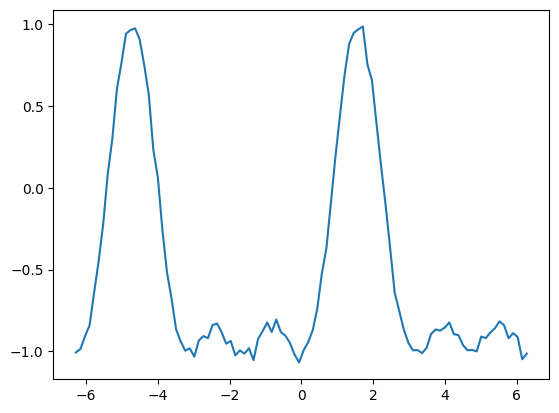

In [4]:
# -- 训练数据的生成 --
#  显示带噪声的曲线

sin_x = np.linspace(-2*np.pi, 2*np.pi, 100)
# sin_y = np.sin(sin_x) ** 3 - np.cos(sin_x) ** 2 + 0.1 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声
sin_y = np.sin(sin_x) ** 3 - np.cos(sin_x) ** 2 + 0.03 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声

# 画图
plt.plot(sin_x, sin_y)
plt.show()

n_sample = len(sin_x)-n_time  # 样本数量
input_data = np.zeros((n_sample, n_time, n_in))  # 输入数据
correct_data = np.zeros((n_sample, n_out))  # 正确答案
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 正确答案位于输入数据的后一位

In [5]:
# -- LSTM网络层 -- 
class LSTMLayer:
    def __init__(self, n_upper, n):
        # 各项参数的初始值
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n_upper)  # Xavier的初始值
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))

    def forward(self, x, y_prev, c_prev):  # y_prev, c_prev: 前一时刻的输出数据与记忆单元
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)

        a0 = sigmoid(u[0])  # 忘记门
        a1 = sigmoid(u[1])  # 输入门
        a2 = np.tanh(u[2])  # 控制门--新的记忆 
        a3 = sigmoid(u[3])  # 输出门
        self.gates = np.stack((a0, a1, a2, a3))

        self.c = a0*c_prev + a1*a2  # 记忆单元 
        self.y = a3 * np.tanh(self.c)  # 输出数据
    
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):   
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + (grad_y*a3) * (1-tanh_c**2)

        # 各项delta
        delta_a0 = r * c_prev * a0 * (1-a0)
        delta_a1 = r * a2 * a1 * (1-a1)
        delta_a2 = r * a1 * (1 - a2**2)
        delta_a3 = grad_y * tanh_c * a3 * (1 - a3)

        deltas = np.stack((delta_a0, delta_a1, delta_a2, delta_a3))

        # 各项参数的的梯度
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)

        # x的梯度
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)

        # y_prev的梯度
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        # c_prev的梯度
        self.grad_c_prev = r * a0

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b



In [6]:
# -- 全连接 输出层 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等函数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b


In [7]:
# -- 各网络层的初始化 --
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [8]:
# -- 训练函数 --
def train(x_mb, t_mb):
    # 正向传播 LSTM网络层
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)

        y = lstm_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        c = lstm_layer.c
        c_rnn[:, i+1, :] = c
        c_prev = c

        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 正向传播 输出层
    output_layer.forward(y)

    # 反向传播 输出层
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)

    # 反向传播 LSTM网络层
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        c = c_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev

    # 参数的更新
    lstm_layer.update(eta)
    output_layer.update(eta)



In [9]:
# -- 预测 --
def predict(x_mb):
    # 正向传播 LSTM网络层
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c

    # 正向传播 输出层
    output_layer.forward(y)
    return output_layer.y



In [10]:
# -- 计算误差 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 误差平方和


Epoch:1/500 Error:6.329558810420677


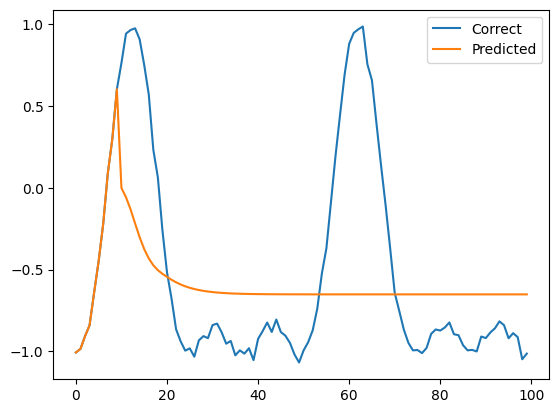

Epoch:11/500 Error:1.2099944428021003


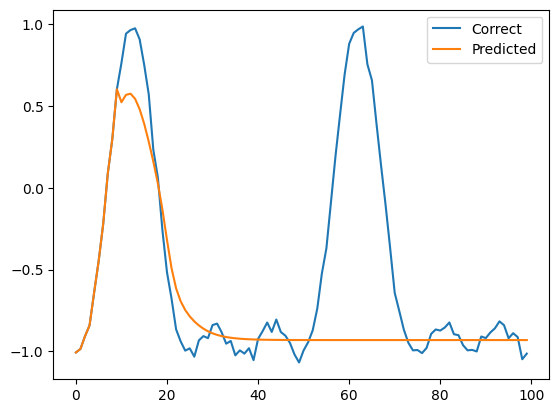

Epoch:21/500 Error:0.5493762114234947


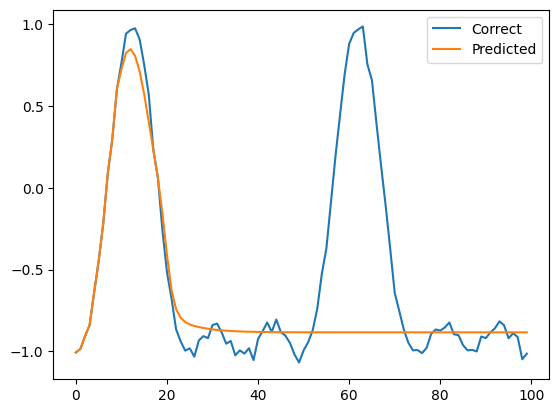

Epoch:31/500 Error:0.40555207624544115


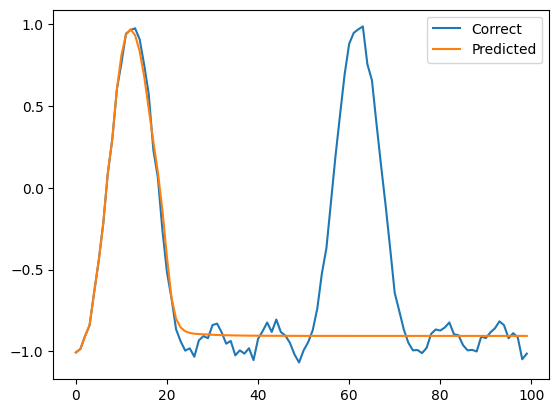

Epoch:41/500 Error:0.35420269484571437


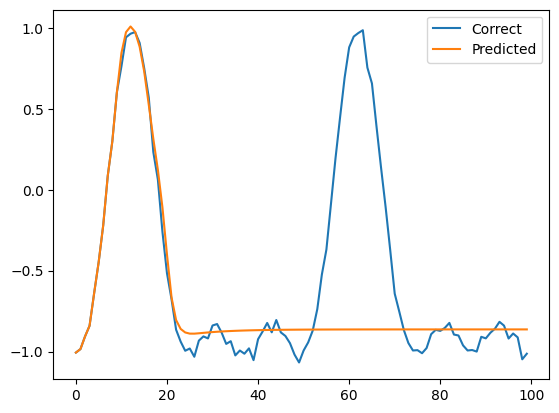

Epoch:51/500 Error:0.32354147678926604


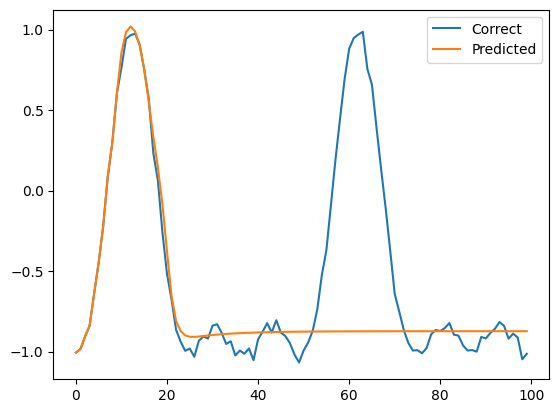

Epoch:61/500 Error:0.30029694974324833


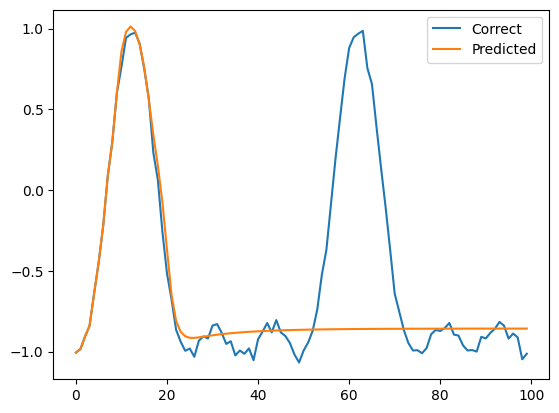

Epoch:71/500 Error:0.2832418925802642


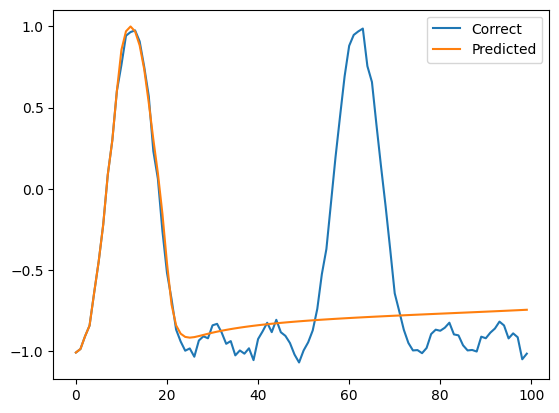

Epoch:81/500 Error:0.2692294218087726


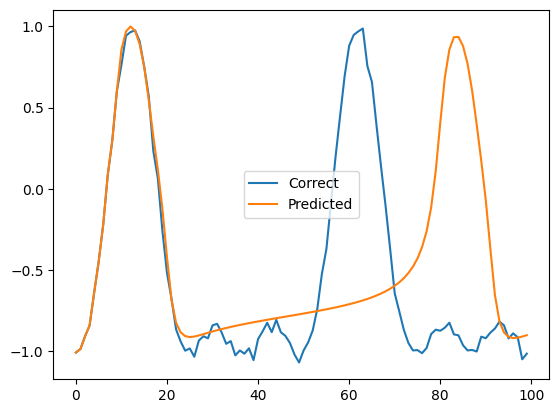

Epoch:91/500 Error:0.2572635647534322


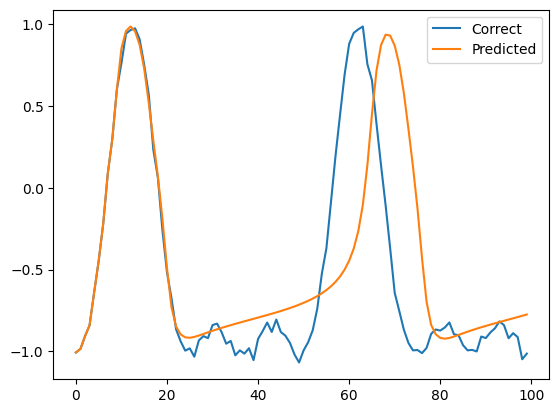

Epoch:101/500 Error:0.24397722533169738


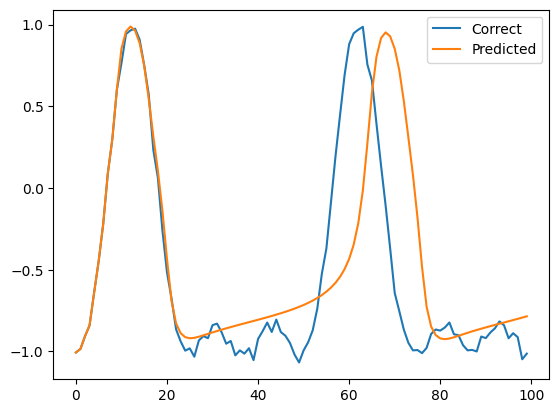

Epoch:111/500 Error:0.23138808676802194


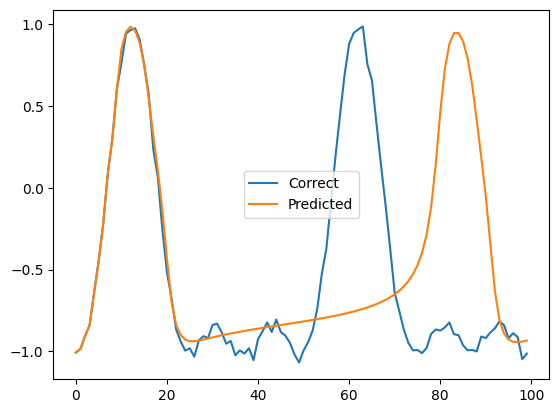

Epoch:121/500 Error:0.22415019530147587


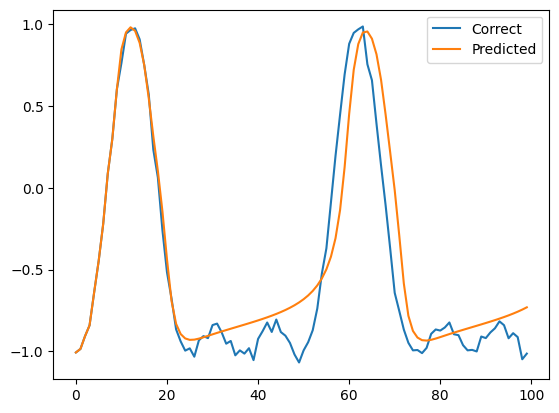

Epoch:131/500 Error:0.2188270483769734


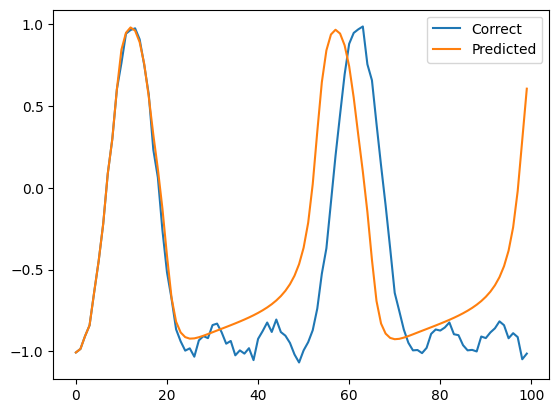

Epoch:141/500 Error:0.209922902870409


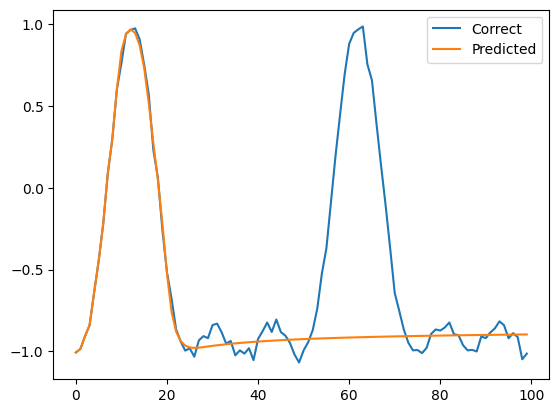

Epoch:151/500 Error:0.20131053064066196


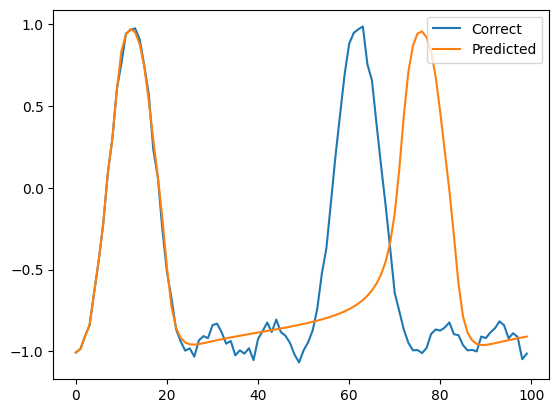

Epoch:161/500 Error:0.1957898128843207


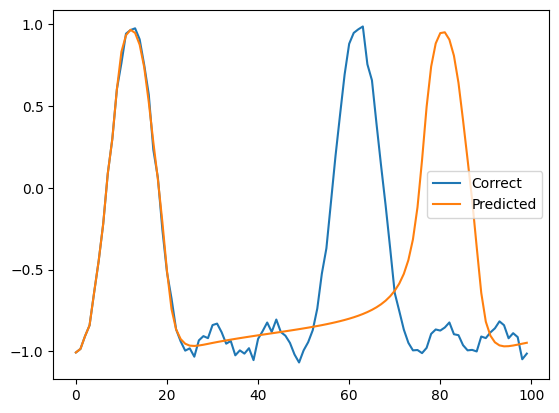

Epoch:171/500 Error:0.19094653223115685


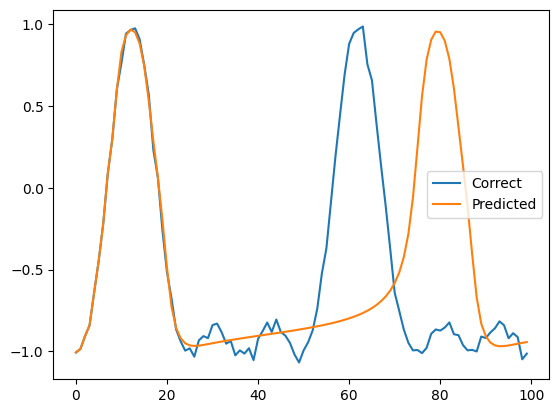

Epoch:181/500 Error:0.18704522660881726


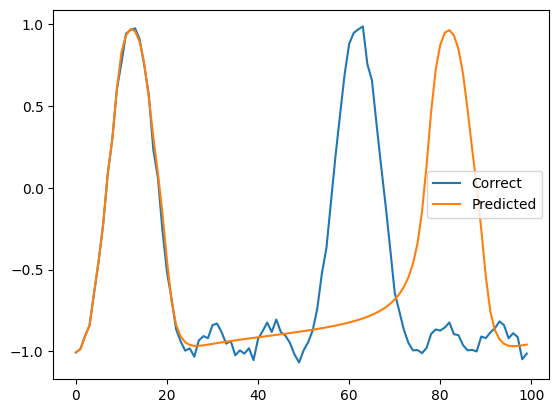

Epoch:191/500 Error:0.18413417152165304


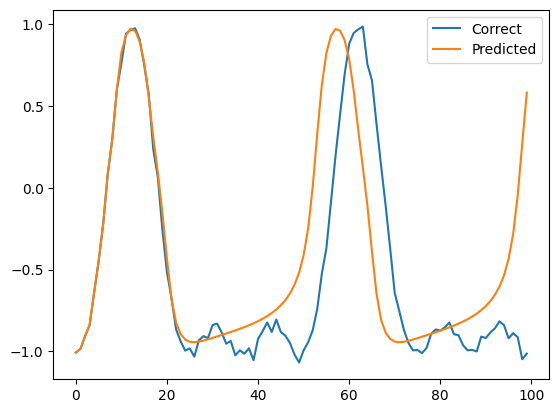

Epoch:201/500 Error:0.17885421418392397


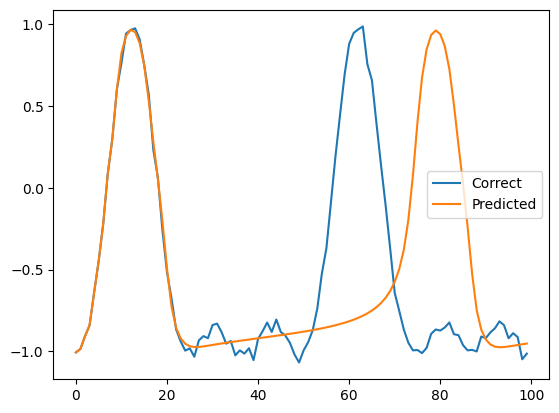

Epoch:211/500 Error:0.1767152192964265


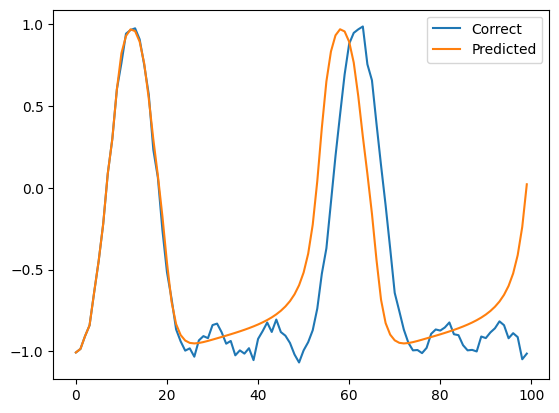

Epoch:221/500 Error:0.17328051606180858


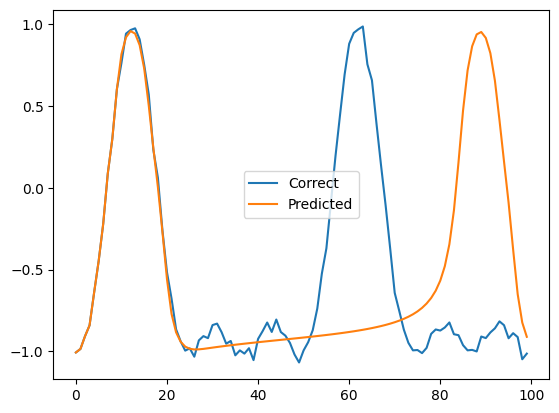

Epoch:231/500 Error:0.17274263460307648


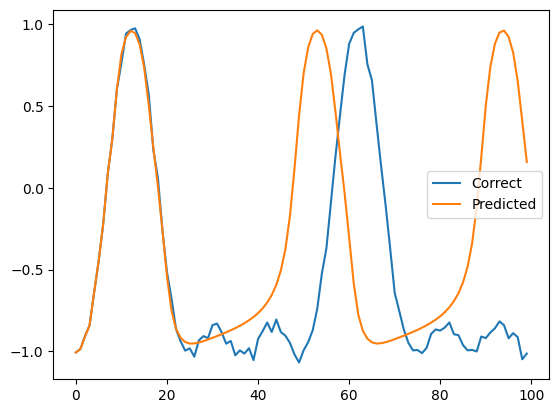

Epoch:241/500 Error:0.16785899020937553


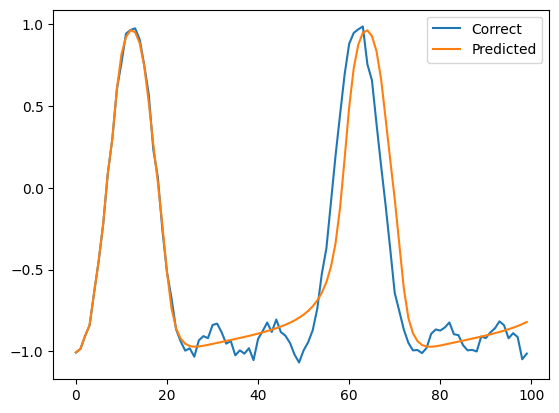

Epoch:251/500 Error:0.1659383628013236


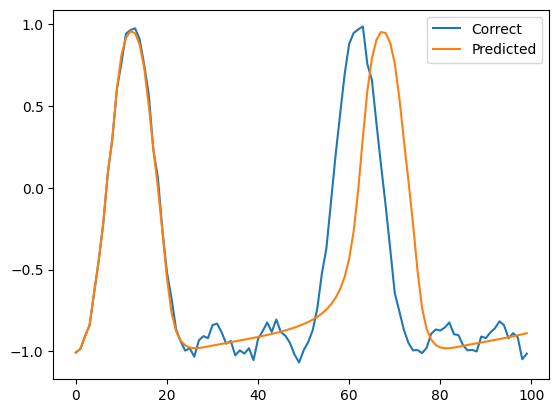

Epoch:261/500 Error:0.16456278994560872


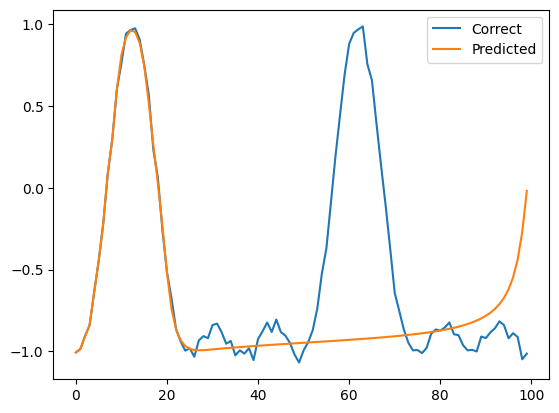

Epoch:271/500 Error:0.1637802567232968


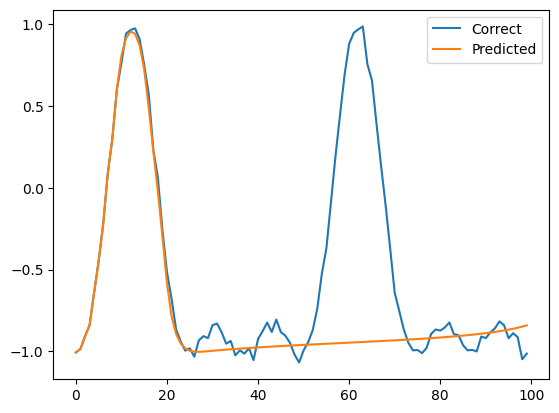

Epoch:281/500 Error:0.1626614263013083


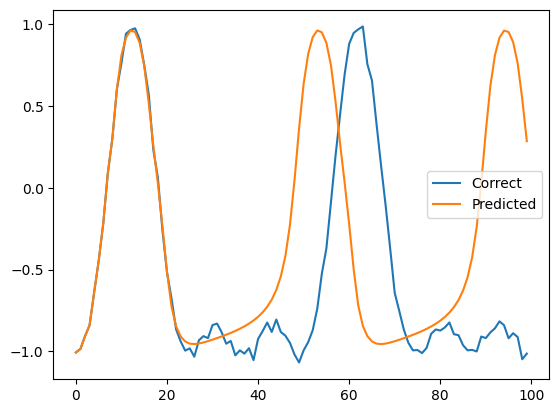

Epoch:291/500 Error:0.16144439390421295


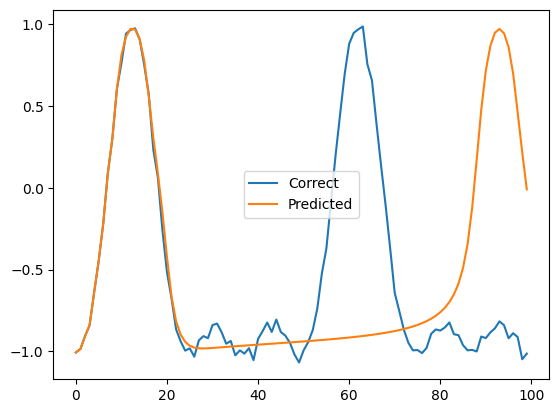

Epoch:301/500 Error:0.15861355176423717


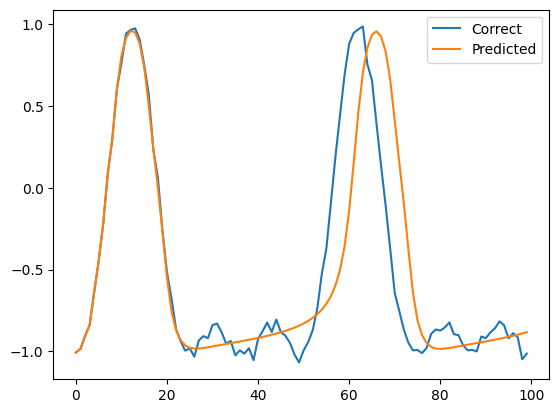

Epoch:311/500 Error:0.15776233138131504


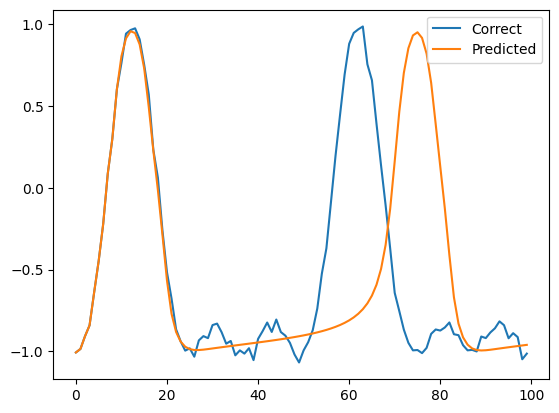

Epoch:321/500 Error:0.15656065832150703


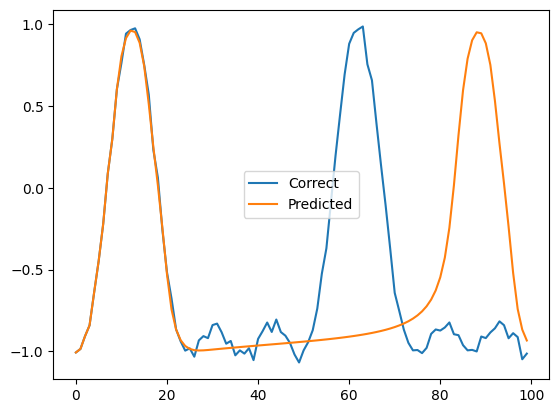

Epoch:331/500 Error:0.15552546919883353


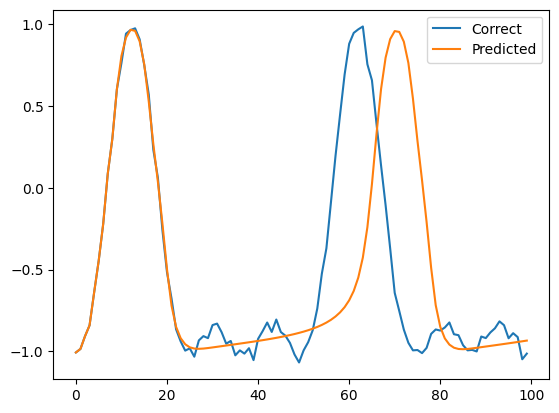

Epoch:341/500 Error:0.1561109991390544


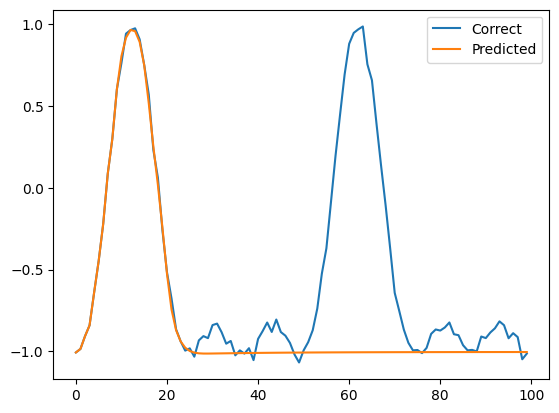

Epoch:351/500 Error:0.15515669874601914


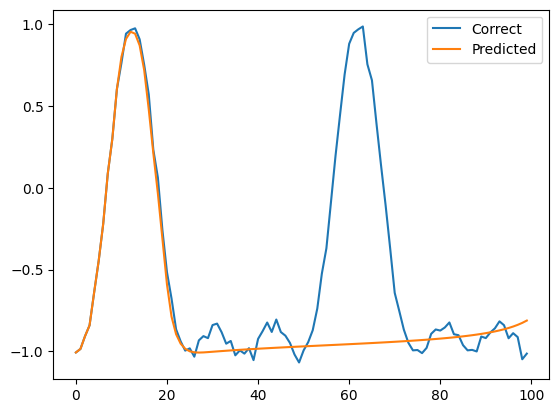

Epoch:361/500 Error:0.15348517441986187


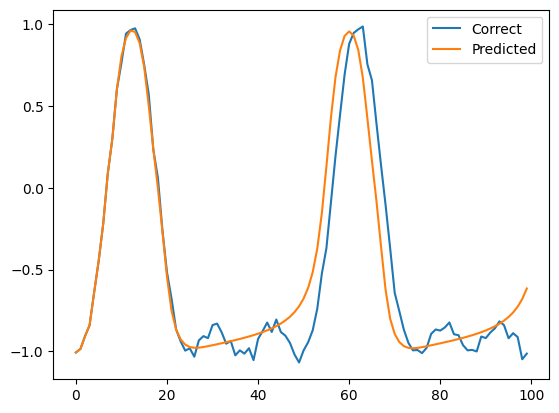

Epoch:371/500 Error:0.15269073770992034


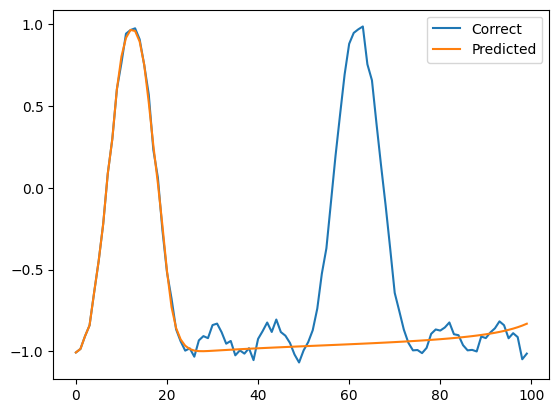

Epoch:381/500 Error:0.15541707657624892


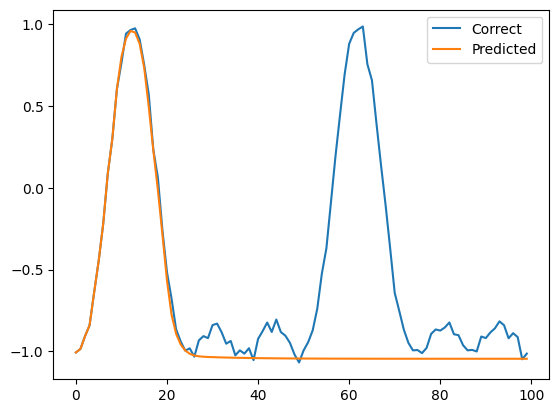

Epoch:391/500 Error:0.15101489975327


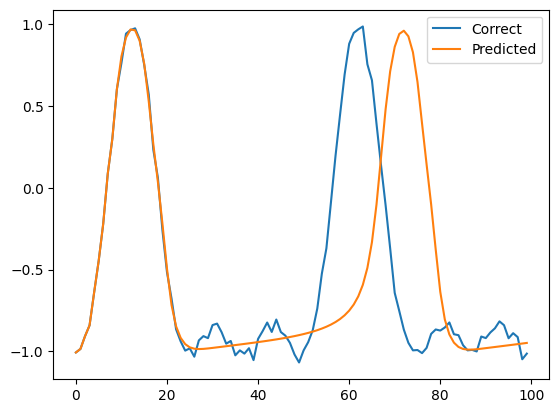

Epoch:401/500 Error:0.15414044825972012


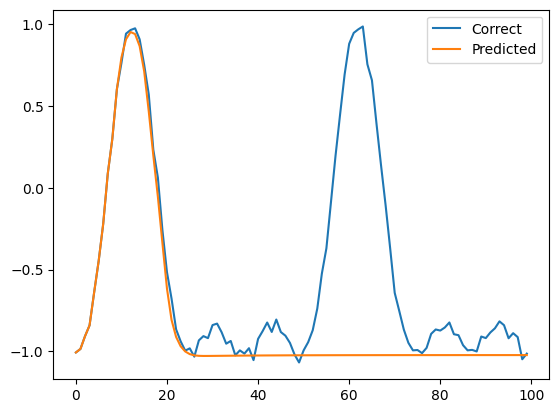

Epoch:411/500 Error:0.15076581900296257


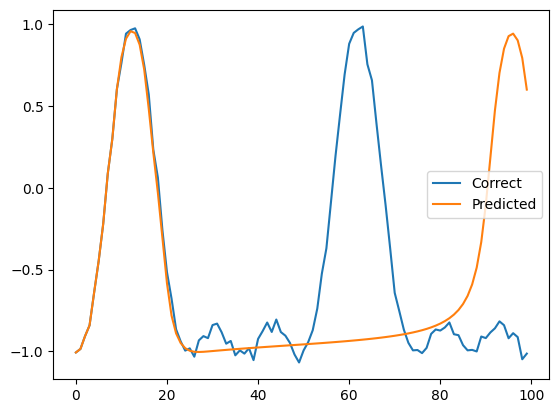

Epoch:421/500 Error:0.15196180042771973


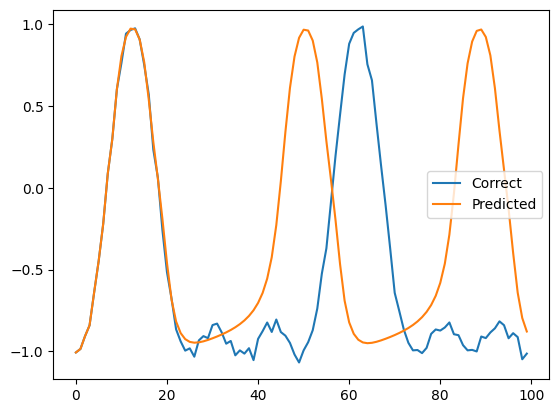

Epoch:431/500 Error:0.1486247426726001


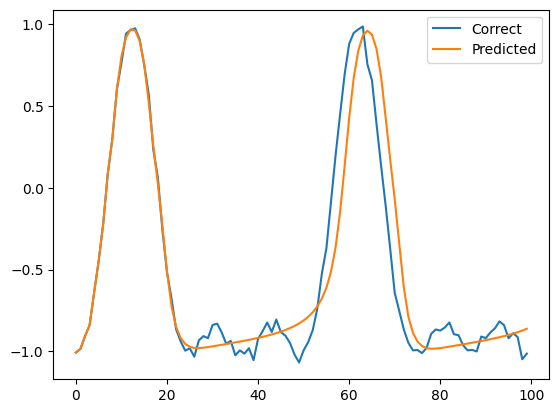

Epoch:441/500 Error:0.148259272659214


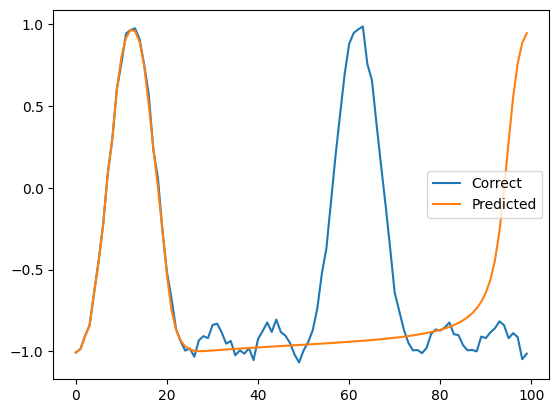

Epoch:451/500 Error:0.14912624091674784


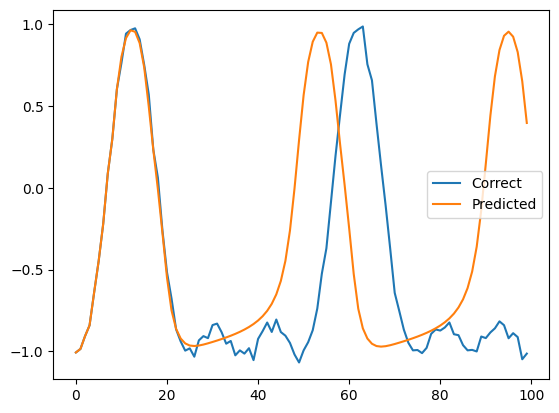

Epoch:461/500 Error:0.1489396577906523


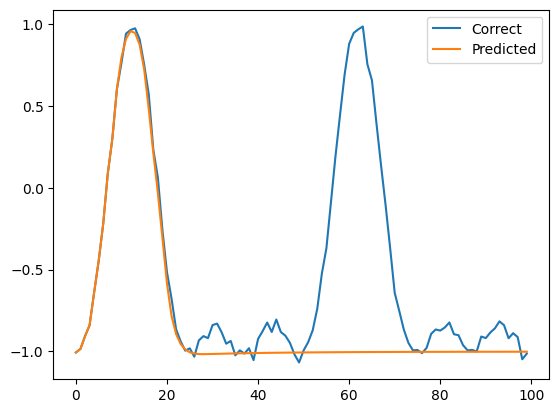

Epoch:471/500 Error:0.1477064164528742


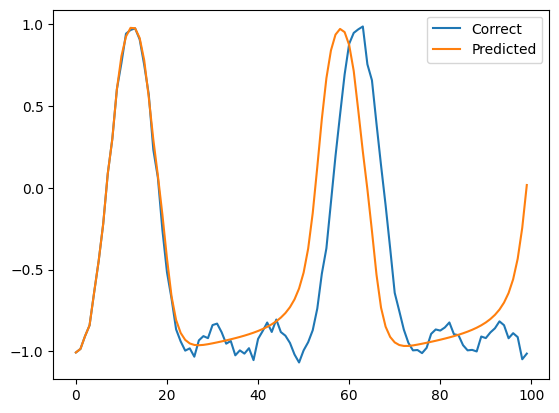

Epoch:481/500 Error:0.14605745298409306


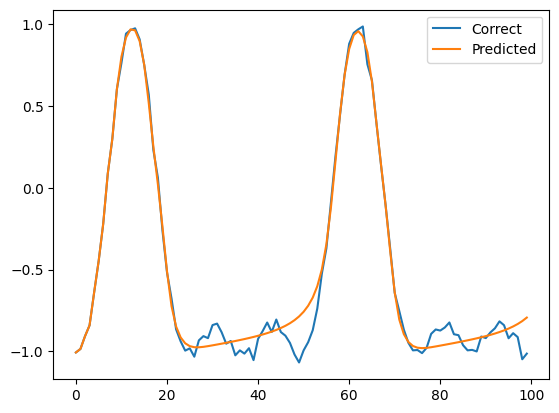

Epoch:491/500 Error:0.14670210043498844


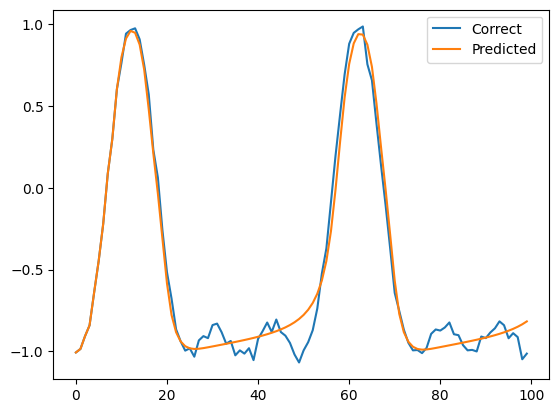

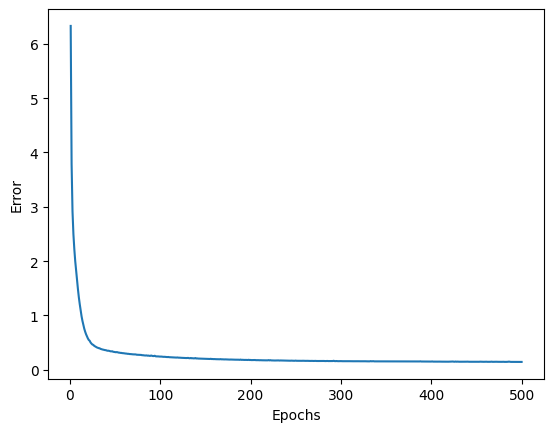

In [11]:
error_record = []
n_batch = len(input_data) // batch_size  # 每轮epoch的批次数量
for i in range(epochs):
        
    # -- 学习 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # 对索引进行打乱处理
    for j in range(n_batch):
        
        # 取出小批次数据
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # -- 计算误差 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 显示进度 -- 
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 最初的输入
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # 将输出添加到predicted中

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()